In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

In [42]:
def gillepsie_first(beta, gamma, mu, nu, initial_state, t):
    
    X, Y, Z = initial_state
    events = ["birth", "trans", "rec", "x_d", "y_d", "z_d"]

    # create the event matrix columns are x, y, z changes rows events
    event_matrix = np.array([[1, 0, 0], # birth
                            [-1, 1, 0], # trans
                            [0, -1, 1], # recovery
                            [-1, 0, 0], # X death
                            [0, -1, 0], # Y death
                            [0, 0, -1]  # Z death
                            ])
    
    t_current = 0
    t_max = t

    # keep live array of pop
    pop = np.array([X, Y, Z])
    u = np.random.default_rng()
    
    # storage
    X_list = [X]
    Y_list = [Y]
    Z_list = [Z]
    t_list = [0]

    while t_current < t_max and pop[1]:
        N = np.sum(pop)
        
        # calculate event rates
        birth_rate = nu * N
        inf_rate = beta * X * Y / N   
        rec_rate = gamma * Y

        # each group has individual death rate 
        X_d_rate = mu * X
        Y_d_rate = mu * Y
        z_d_rate = mu * Z

        rates = np.array([birth_rate, inf_rate, rec_rate,
                X_d_rate, Y_d_rate, z_d_rate])


        scales = np.divide(1.0, rates, out=np.full_like(rates, np.inf), where=rates > 0)
        wait_t = u.exponential(scales)
        
        # find closest event and its waiting time
        closest_event = np.argmin(wait_t)
        dt = wait_t[closest_event]
        
        # update population and time
        pop += event_matrix[closest_event]
        t_current += dt
        
        X, Y, Z = pop
        
        t_list.append(t_current)
        X_list.append(X)
        Y_list.append(Y)
        Z_list.append(Z)

    return X_list, Y_list, Z_list, t_list


In [43]:
class Gillespie():
    def __init__(self, beta, gamma, mu, nu, initial_state, t, dt):
        self.b = beta
        self.g = gamma
        self.m = mu 
        self.n = nu
        self.X, self.Y, self.Z = initial_state
        self.t = np.arange(0, t, dt)
        self.dt = dt
        self.N = self.X + self.Y + self.Z

    def update_rates(self):
        # calculate event rates
        self.inf_rate = self.b * self.X * self.Y / self.N
        self.birth_rate = self.n * self.N
        self.rec_rate = self.g * self.Y

        # each group has individual death rate 
        self.X_d_rate = self.m * self.X
        self.Y_d_rate = self.m * self.Y
        self.z_d_rate = self.m * self.Z

    



In [95]:
def get_max_inf_peak(Y, t):
    max_idx = np.argmax(Y)
    peak_Y = Y[max_idx]
    peak_t = t[max_idx]

    return peak_Y, peak_t

[9995, np.int64(9996), np.int64(9995), np.int64(9994), np.int64(9995)]


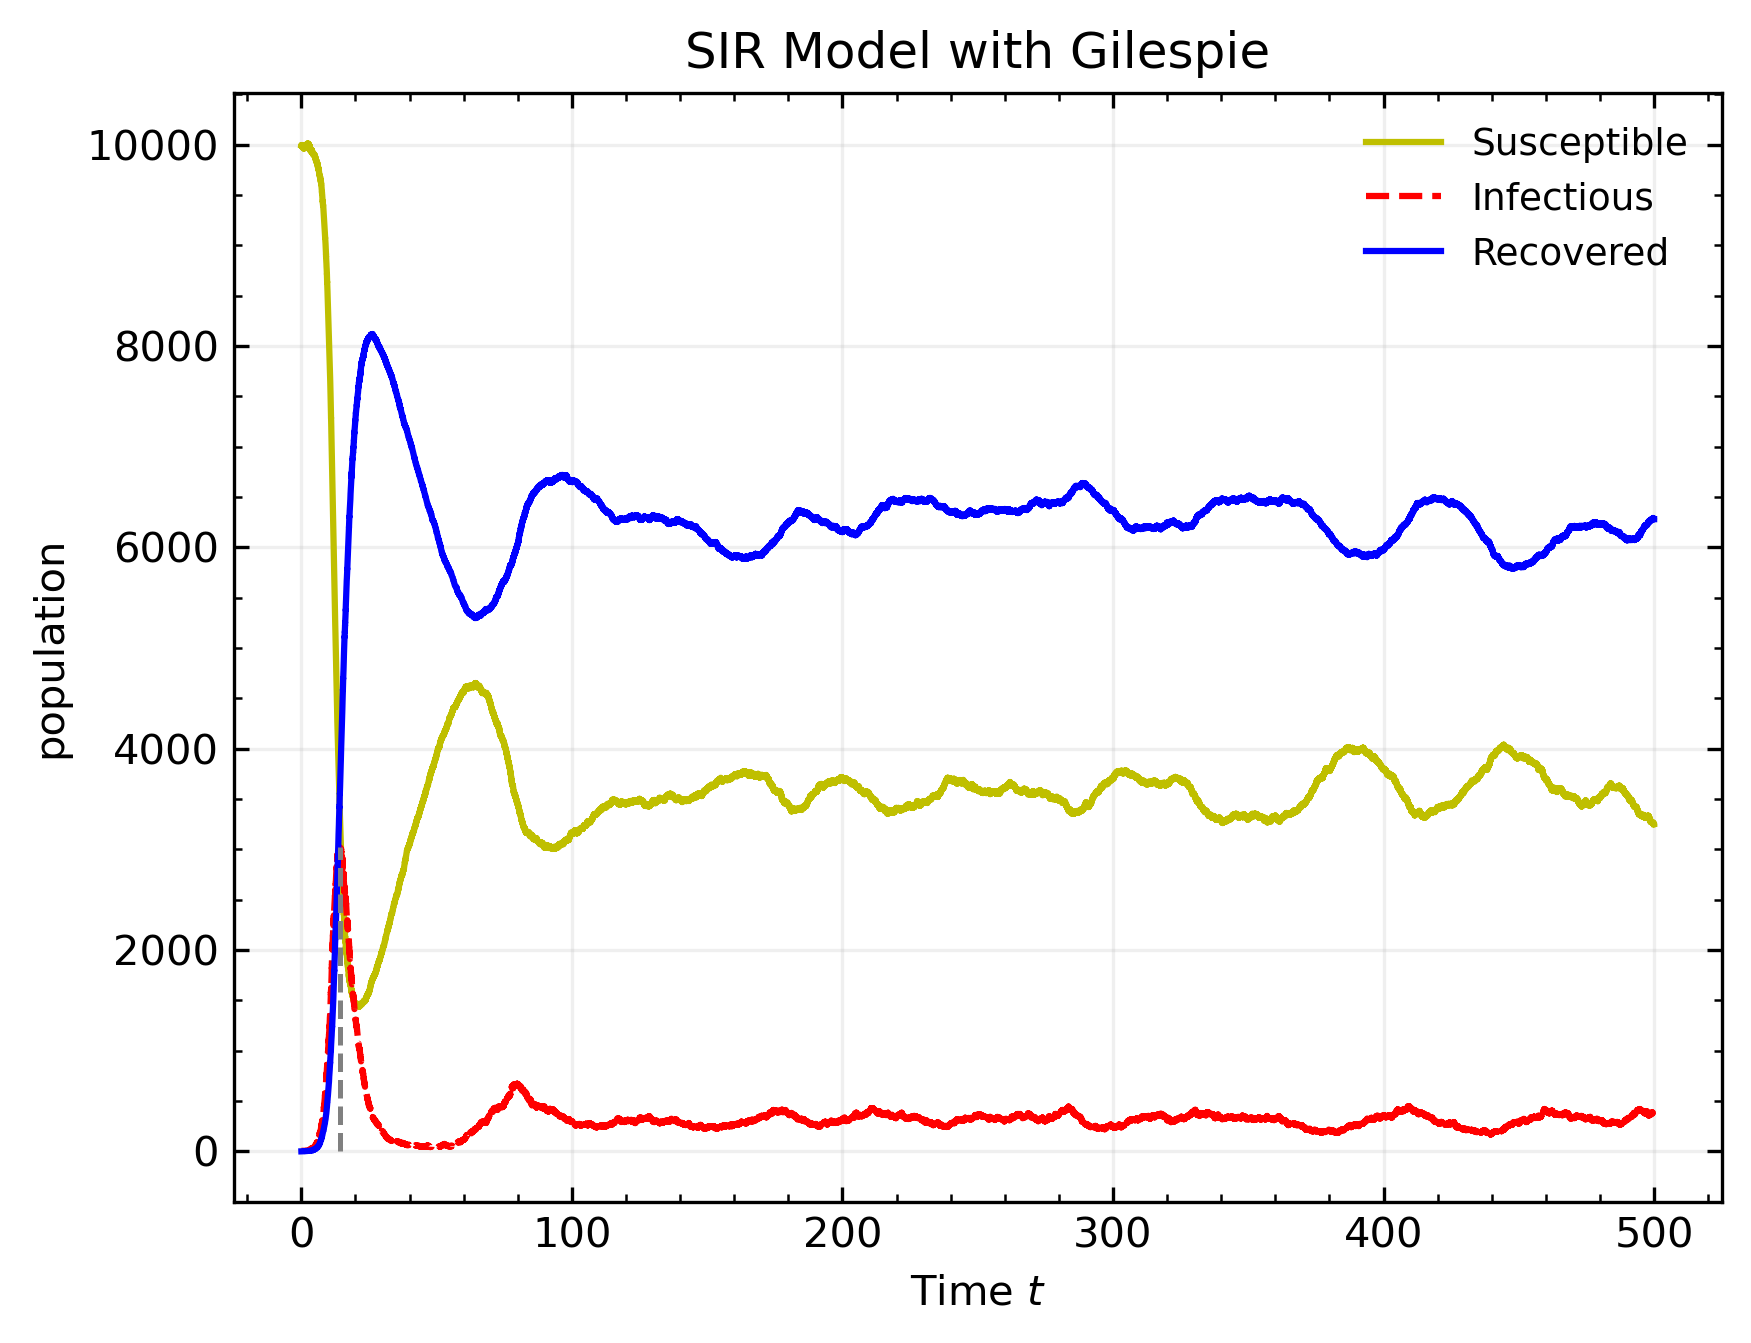

In [96]:
# parameters
g = 1/3
m = n = 1/(60)

b = 1
t = 500
N = 10000
Y = 5
X = N - Y
Z = 0

initial_state = X, Y, Z

X, Y, Z, t = gillepsie_first(b, g, m, n, initial_state, t)
print(X[0:5])

# plot results from odeint as test
fig, ax = plt.subplots(dpi=300)
# plot S, I, R
ax.plot(t, X, 'y-', label='Susceptible' )
ax.plot(t, Y, 'r--', label='Infectious')
ax.plot(t, Z, 'b-', label='Recovered')
# set labels
ax.set_ylabel('population')
ax.set_xlabel('Time $t$')
# add legend, ticks, grid
ax.set_title('SIR Model with Gilespie')
ax.legend(frameon=False, fontsize=9)
ax.tick_params(which="both", direction="in", top=True, right=True)

# add vertical line at peak infection
peak_val, peak_time = get_max_inf_peak(Y, t)
ax.vlines(x=peak_time, ymin=0, ymax=peak_val, color="gray", ls="--", lw=1.2, label="Peak infection")


ax.minorticks_on()
ax.grid(alpha=0.2)


In [ ]:
# Investigate Simulation Variability and Negative Co-variance
def run_gillespie(initial_state, beta, gamma, mu, nu, t_max, n_runs):
    X, Y, Z = initial_state
    t_common = np.arange(0, t_max, 0.5)
    all_trajectories = dict()

    # results = np.zeros(N, )
    for i in range(n_runs):
        t_list, X_path, Y_path, Z_path = gillespie_sir(X, Y, Z, beta, gamma, mu, nu, t_max)
        s_i_dict = dict(zip(t_list, zip(X_path, Y_path)))
        trajectory = dict()

        for time in t_common:
            for t, xy in s_i_dict.items():
                if t <= time:
                    trajectory[time] = xy
                
                else:
                    break
        all_trajectories[i] = trajectory
    return all_trajectories